In [32]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os 
import imageio
import scipy.io as spio
import cv2
from numpy.linalg import det, inv
import matplotlib.image as mpimg
from matplotlib.widgets import PolygonSelector
from PIL import Image
import dlib

plt.style.use('default')

Task1

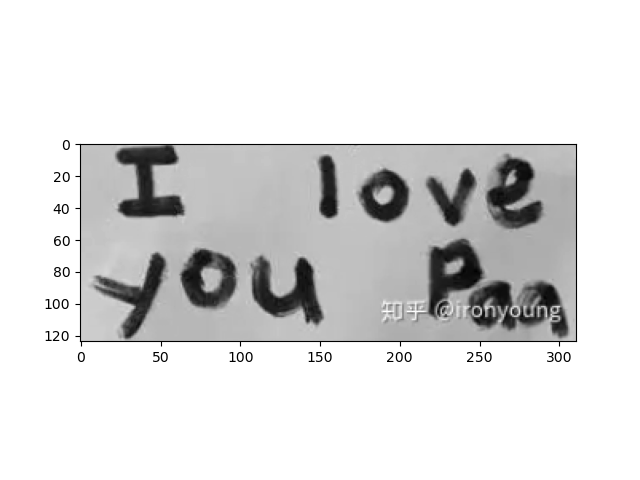

Polygon vertices:
[(3.061913078061991, 3.3874980864986313), (122.19497759419103, 2.133465828434119), (120.31392920709426, 306.8633045381115), (1.180864690965194, 307.4903206671438)]


In [139]:
# 确保您替换了以下路径为您的图像路径
img_path = "InputImgs\\1.png"
img = Image.open(img_path).convert('L')
img_array = np.array(img, dtype=np.uint8)  # 确保数据类型为 uint8

# 回调函数，当选择完成时调用
def onselect(verts):
    global polygon
    polygon = [(y, x) for x, y in verts]
    print("Polygon vertices:")
    print(polygon)
    # 这里可以添加代码来处理多边形的顶点

# 创建图像和轴
fig, ax = plt.subplots()
ax.imshow(img_array, cmap='gray')

# 创建PolygonSelector实例
polygon_selector = PolygonSelector(ax, onselect)

# 显示图像并开始多边形选择过程
plt.show()

[145.93568328 144.51412245 144.38574244 ... 171.22859525 143.45276532
 134.90116992]
[146 145 144 ... 171 143 135]


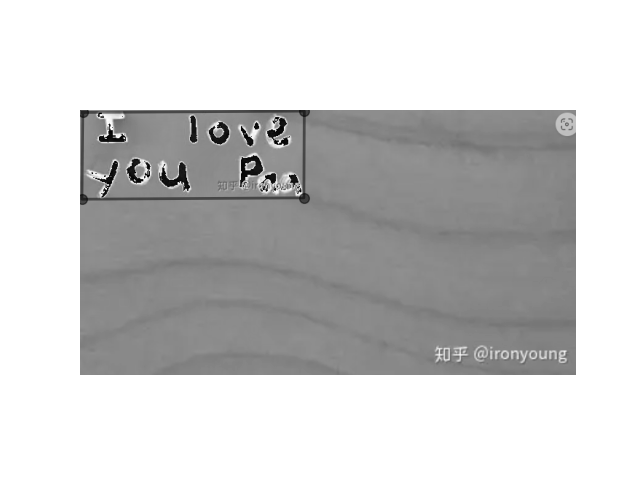

In [140]:
from skimage.draw import polygon2mask
from scipy.sparse.linalg import spsolve
from scipy import signal
from scipy.sparse import lil_matrix
from scipy.sparse import csr_matrix

# 请确保源图像和目标图像已正确加载，并且多边形区域已定义
source_img_path = "InputImgs\\1.png"
target_img_path = "InputImgs\\2.png"
source_img = Image.open(source_img_path).convert('L')
target_img = Image.open(target_img_path).convert('L')
source_img_array = np.array(source_img, dtype=np.uint8)
target_img_array = np.array(target_img, dtype=np.uint8)

mask = polygon2mask(img_array.shape, polygon)
# 计算源图像的拉普拉斯算子
laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
grad_source = signal.convolve2d(source_img_array, laplacian, mode='same', boundary='fill', fillvalue=0)

# 找出掩码内的索引和边界索引
idx = np.argwhere(mask)
boundary_idx = np.argwhere(np.gradient(mask.astype(int)) != 0)

# 将边界索引转换为元组的列表
boundary_tuples = list(map(tuple, boundary_idx))

# 建立系数矩阵A和向量b
n_pixels = len(idx)
A = lil_matrix((n_pixels, n_pixels))
b = np.zeros(n_pixels)

# 填充系数矩阵A和向量b
for i, (row, col) in enumerate(idx):
    A[i, i] = 4
    for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        neighbor = (row + drow, col + dcol)
        # 确保邻居索引不会越界
        if (0 <= neighbor[0] < mask.shape[0]) and (0 <= neighbor[1] < mask.shape[1]):
            if mask[neighbor]:  # 如果邻居在掩码内
                j = np.argwhere((idx == neighbor).all(axis=1))
                if j.size > 0:
                    A[i, j[0][0]] = -1
            else:  # 如果邻居在边界上
                b[i] += target_img_array[neighbor]
    # 如果当前点不在边界上，则加上源图像的拉普拉斯值
    if (row, col) not in boundary_tuples:
        b[i] += grad_source[row, col]

# 边界点的处理：源图像值替代目标图像值
for point in boundary_tuples:
    if point in map(tuple, idx):  # 确保边界点也在掩码内
        i = list(map(tuple, idx)).index(point)
        b[i] = source_img_array[point]

solution = spsolve(A.tocsr(), b)
print(solution)
# 舍入到最近的整数，并转换为 np.uint8 类型
solution = np.round(solution).astype(np.uint8)
# solution = np.clip(solution, 0, 255)
print(solution)

filled_img_array = target_img_array.copy()
for (row, col), value in zip(idx, solution):
    filled_img_array[row, col] = value

plt.imshow(filled_img_array, cmap='gray')
plt.axis('off')
plt.show()

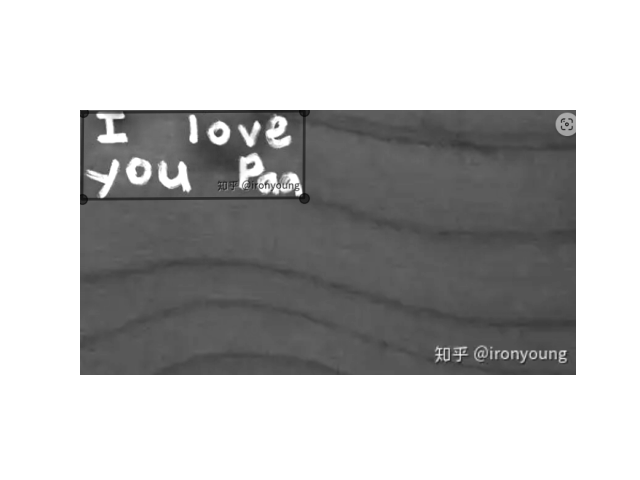

array([[149, 149, 149, ..., 136, 136, 136],
       [149, 149, 149, ..., 136, 136, 136],
       [149, 149, 149, ..., 136, 136, 136],
       ...,
       [136, 136, 136, ..., 125, 125, 124],
       [137, 137, 137, ..., 124, 124, 124],
       [137, 137, 137, ..., 124, 124, 124]], dtype=uint8)

In [141]:
def compute_gradients(img):
    """Compute gradients of the image using forward differencing."""
    gx = np.roll(img, -1, axis=1) - img
    gy = np.roll(img, -1, axis=0) - img
    return gx, gy

def seamless_cloning(source_img, target_img, mask, polygon, mode='importing'):
    # 创建拉普拉斯算子
    laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    
    # 计算源图像的拉普拉斯算子
    grad_source = signal.convolve2d(source_img, laplacian, mode='same', boundary='fill', fillvalue=0)
    
    # 获取掩码内的索引
    idx = np.argwhere(mask)
    
    # 创建系数矩阵A和向量b
    n_pixels = len(idx)
    A = lil_matrix((n_pixels, n_pixels))
    b = np.zeros(n_pixels)
    
    for i, (row, col) in enumerate(idx):
        A[i, i] = 4
        for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            neighbor = (row + drow, col + dcol)
            if (0 <= neighbor[0] < mask.shape[0]) and (0 <= neighbor[1] < mask.shape[1]):
                if mask[neighbor]:
                    j = np.argwhere((idx == neighbor).all(axis=1))
                    if j.size > 0:
                        A[i, j[0][0]] = -1
                else:
                    b[i] += target_img[neighbor]
    
    if mode == 'importing':
        # 使用源图像的拉普拉斯算子
        for i, (row, col) in enumerate(idx):
            b[i] += grad_source[row, col]
    elif mode == 'mixing':
        # 使用源图像和目标图像的最大梯度
        grad_target = signal.convolve2d(target_img, laplacian, mode='same', boundary='fill', fillvalue=0)
        for i, (row, col) in enumerate(idx):
            if abs(grad_source[row, col]) > abs(grad_target[row, col]):
                b[i] += grad_source[row, col]
            else:
                b[i] += grad_target[row, col]
    
    # 解线性方程组
    solution = spsolve(A.tocsr(), b)
    
    # 创建一个新的目标图像以填充结果
    cloned_img = target_img.copy()
    for (row, col), value in zip(idx, solution):
        cloned_img[row, col] = np.clip(value, 0, 255)

    plt.imshow(cloned_img, cmap='gray')
    plt.axis('off')
    plt.show()
    return cloned_img

# 使用导入梯度
#seamless_cloning(source_img_array, target_img_array, mask, polygon, mode='importing')
seamless_cloning(source_img_array, target_img_array, mask, polygon, mode='mixing')

In [145]:
def seamless_cloning(source_img, target_img, mask, mode='importing'):
    # Ensure mask is boolean
    mask = mask.astype(bool)
    idx = np.argwhere(mask)

    # Create coefficient matrix A
    n_pixels = len(idx)
    A = lil_matrix((n_pixels, n_pixels))
    for i, index in enumerate(idx):
        y, x = index
        A[i, i] = 4
        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            neighbor_y, neighbor_x = y + dy, x + dx
            if 0 <= neighbor_y < mask.shape[0] and 0 <= neighbor_x < mask.shape[1]:
                if mask[neighbor_y, neighbor_x]:
                    j = np.argwhere((idx == [neighbor_y, neighbor_x]).all(axis=1))
                    if j.size > 0:
                        A[i, j] = -1

    # Create Laplacian operator
    laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

    # Clone for each color channel
    cloned_img = np.copy(target_img)
    for channel in range(3):  # for each color channel
        source_channel = source_img[:, :, channel]
        target_channel = target_img[:, :, channel]

        # Compute gradients
        grad_source = signal.convolve2d(source_channel, laplacian, mode='same', boundary='fill', fillvalue=0)

        # Build the vector b
        b = np.zeros(n_pixels)
        for i, (y, x) in enumerate(idx):
            b[i] = 4 * target_channel[y, x]  # Initialize b with target image values

        if mode == 'importing':
            b += grad_source[idx[:, 0], idx[:, 1]]
        elif mode == 'mixing':
            grad_target = signal.convolve2d(target_channel, laplacian, mode='same', boundary='fill', fillvalue=0)
            for i, (y, x) in enumerate(idx):
                if abs(grad_source[y, x]) > abs(grad_target[y, x]):
                    b[i] += grad_source[y, x]
                else:
                    b[i] += grad_target[y, x]

        # Solve the linear system
        solution = spsolve(A.tocsr(), b)

        # Apply the solution to the cloned image
        for i, (y, x) in enumerate(idx):
            cloned_img[y, x, channel] = np.clip(solution[i], 0, 255)

    # Convert the cloned image from BGR to RGB before displaying
    cloned_img_rgb = cv2.cvtColor(cloned_img, cv2.COLOR_BGR2RGB)
    plt.imshow(cloned_img_rgb)
    plt.axis('off')
    plt.show()
    
    return cloned_img


source_img_path = "InputImgs\\1.png"
target_img_path = "InputImgs\\2.png"
source_img = cv2.imread(source_img_path, cv2.IMREAD_COLOR)  # 确保使用cv2.IMREAD_COLOR读取彩色图像
target_img = cv2.imread(target_img_path, cv2.IMREAD_COLOR)


# 使用导入梯度
result = seamless_cloning(source_img, target_img, mask.astype(bool), mode='mixing')

# 展示结果
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
